In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import h5py 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import copy 
from scipy.io import savemat
from sklearn import metrics as skmetric

## Load datasets
1. Load noisy datasets to train the mimmax_scaler
2. Load clean data to train MLPclean
3. Load noisy data to train MLPnoisy

In [2]:
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)
snr_training_weights= np.flip(len(all_snrs)-np.arange(len(all_snrs)))/len(all_snrs)
print(snr_training_weights)

root_data_dir= '../Datasets/psd_gp_vIHC_mat/PyData/'


# Load clean data 
train_test_dataset = h5py.File(root_data_dir + 'PSD_data_clean.h5', "r")
data_x_clean_orig = np.array(train_test_dataset["data_psd_x"][:]) # your train set features
data_y_clean_orig = np.ravel(np.array(train_test_dataset["data_label_y"][:])) # your train set labels
data_clean_fnames = np.ravel(np.array(train_test_dataset["data_filename"][:])) # your train set labels

train_inds, test_inds = train_test_split(np.arange(data_x_clean_orig.shape[0]), test_size=0.25, random_state=1)

all_train_x_orig = data_x_clean_orig[train_inds,:]
all_train_y_orig = data_y_clean_orig[train_inds]

# Load all SNR data 
for snr_value,snr_weight in zip(all_snrs[0:-1], snr_training_weights[0:-1]):
    print(f"SNR={snr_value} dB and weight = {snr_weight}")
    out_psd_data_file = root_data_dir + 'PSD_data_SNR' + snr_value.astype('int').astype('str') + '.h5'    
    cur_dataset = h5py.File(out_psd_data_file, "r")
        
    cur_x = np.array(cur_dataset["data_psd_x"][:])
    cur_y = np.ravel(np.array(cur_dataset["data_label_y"][:]))
    
    sample_inds_training, _= train_test_split(np.arange(len(train_inds)), test_size= 1-snr_weight, random_state=1)

    all_train_x_orig = np.concatenate((all_train_x_orig, cur_x[train_inds[sample_inds_training],:]), axis=0)
    all_train_y_orig = np.concatenate((all_train_y_orig, cur_y[train_inds[sample_inds_training]]))
    print(f"shape:cur={cur_x.shape},cur_subsamp={len(sample_inds_training)}, full={len(train_inds)}, all_train_x_orig={all_train_x_orig.shape},type={type(cur_x)}")

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(all_train_x_orig)

train_set_x_norm = minmax_scaler.transform(data_x_clean_orig)
all_train_x_norm = minmax_scaler.transform(all_train_x_orig)

X_train_clean, X_test_clean, y_train_clean, y_test_clean, train_inds, test_inds, train_fnames, test_fnames = train_test_split \
    (train_set_x_norm, data_y_clean_orig, np.arange(train_set_x_norm.shape[0]), data_clean_fnames, test_size=0.25, random_state=1)
print(f"Type: X_train_clean={type(X_train_clean)}, y_train_clean={type(y_train_clean)}")
print(f"Shapes: X_train_clean={X_train_clean.shape}, y_train_clean={y_train_clean.shape}, X_test_clean={X_test_clean.shape}, y_test_clean={y_test_clean.shape}")

unq_vals, unq_counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unq_vals,unq_counts)))
    


[0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
SNR=-20.0 dB and weight = 0.125
shape:cur=(1605, 67),cur_subsamp=150, full=1203, all_train_x_orig=(1353, 67),type=<class 'numpy.ndarray'>
SNR=-15.0 dB and weight = 0.25
shape:cur=(1605, 67),cur_subsamp=300, full=1203, all_train_x_orig=(1653, 67),type=<class 'numpy.ndarray'>
SNR=-10.0 dB and weight = 0.375
shape:cur=(1605, 67),cur_subsamp=451, full=1203, all_train_x_orig=(2104, 67),type=<class 'numpy.ndarray'>
SNR=-5.0 dB and weight = 0.5
shape:cur=(1605, 67),cur_subsamp=601, full=1203, all_train_x_orig=(2705, 67),type=<class 'numpy.ndarray'>
SNR=0.0 dB and weight = 0.625
shape:cur=(1605, 67),cur_subsamp=751, full=1203, all_train_x_orig=(3456, 67),type=<class 'numpy.ndarray'>
SNR=5.0 dB and weight = 0.75
shape:cur=(1605, 67),cur_subsamp=902, full=1203, all_train_x_orig=(4358, 67),type=<class 'numpy.ndarray'>
SNR=10.0 dB and weight = 0.875
shape:cur=(1605, 67),cur_subsamp=1052, full=1203, all_train_x_orig=(5410, 67),type=<class 'numpy.nda

## Model #1: An SVM model (rbf kernels seem to work the best)

Unique values in y_test_pred=[0 1 2 3 4]
Unique values in y_train_clean=[0 1 2 3 4]
Training accuracy=0.9650872817955112
 Testing accuracy=0.9626865671641791



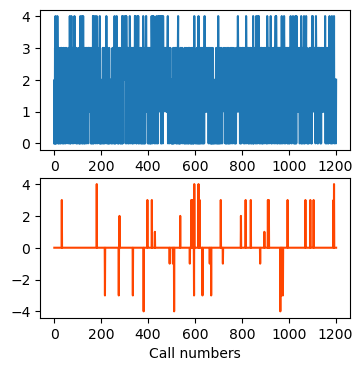

In [3]:
svm_model = svm.SVC(kernel='rbf').fit(X_train_clean, y_train_clean)
y_train_pred = svm_model.predict(X_train_clean)
y_test_pred = svm_model.predict(X_test_clean)

print(f"Unique values in y_test_pred={np.unique(y_test_pred)}")
print(f"Unique values in y_train_clean={np.unique(y_train_clean)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_clean==y_train_pred)/len(y_train_pred)}\n Testing accuracy={np.sum(y_test_clean==y_test_pred)/len(y_test_pred)}\n")

## Model #2. Train an MLP 

In [4]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPclean = Sequential(
    [
        Dense(10, activation = 'relu',   name = "L1"),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPclean.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

# Fit the model 
MLPclean.fit(
    X_train_clean,y_train_clean,
    epochs=200
)

Epoch 1/200
38/38 [==============================] - 1s 3ms/step - loss: 1.0047
Epoch 2/200
38/38 [==============================] - 0s 1ms/step - loss: 0.3893
Epoch 3/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2639
Epoch 4/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2154
Epoch 5/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1888
Epoch 6/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1834
Epoch 7/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1641
Epoch 8/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1656
Epoch 9/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1554
Epoch 10/200
38/38 [==============================] - 0s 1ms/step - loss: 0.1486
Epoch 11/200
38/38 [==============================] - 0s 2ms/step - loss: 0.1458
Epoch 12/200
38/38 [==============================] - 0s 1000us/step - loss: 0.1484
Epoch 13/200
38/38 [==============

## Test MLP accuracy for training and testing 

13/13 [==============================] - 0s 750us/step
Unique values in y_train_clean=[0 1 2 3 4]
Unique values in y_test_pred=[0 1 2 3 4]
Training accuracy=0.9825436408977556
 Testing accuracy=0.9800995024875622



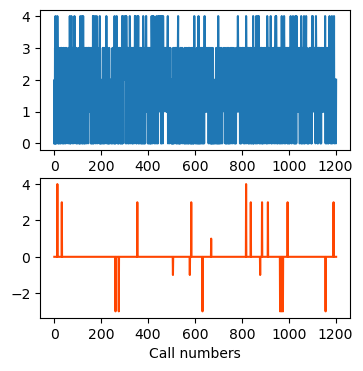

In [5]:
y_train_pred_NN = np.argmax(MLPclean.predict(X_train_clean), axis=1)
y_test_pred_NN = np.argmax(MLPclean.predict(X_test_clean), axis=1)

print(f"Unique values in y_train_clean={np.unique(y_train_pred_NN)}")
print(f"Unique values in y_test_pred={np.unique(y_test_pred_NN)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred_NN, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_clean==y_train_pred_NN)/len(y_train_clean)}\n Testing accuracy={np.sum(y_test_clean==y_test_pred_NN)/len(y_test_clean)}\n")

## Model #3. MLP cleaned on noisy calls 

In [6]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPnoisy = Sequential(
    [
        Dense(10, activation = 'relu',   name = "L1"),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPnoisy.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Fit the model 
MLPnoisy.fit(
    all_train_x_norm, all_train_y_orig,
    epochs=50
)

Epoch 1/50
170/170 [==============================] - 1s 1ms/step - loss: 0.4653 - accuracy: 0.8482
Epoch 2/50
170/170 [==============================] - 0s 1ms/step - loss: 0.1606 - accuracy: 0.9595
Epoch 3/50
170/170 [==============================] - 0s 1ms/step - loss: 0.1213 - accuracy: 0.9665
Epoch 4/50
170/170 [==============================] - 0s 1ms/step - loss: 0.1013 - accuracy: 0.9706
Epoch 5/50
170/170 [==============================] - 0s 935us/step - loss: 0.0925 - accuracy: 0.9739
Epoch 6/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.9754
Epoch 7/50
170/170 [==============================] - 0s 923us/step - loss: 0.0792 - accuracy: 0.9773
Epoch 8/50
170/170 [==============================] - 0s 867us/step - loss: 0.0764 - accuracy: 0.9782
Epoch 9/50
170/170 [==============================] - 0s 885us/step - loss: 0.0754 - accuracy: 0.9795
Epoch 10/50
170/170 [==============================] - 0s 876us/step - loss: 0.0734 - accura

## Test in different SNRs 

In [16]:
def test_MLP_snr(MLPmodel, minmax_scaler, snr_value, test_inds_clean, test_fnames_clean):
    root_out_dir= '../Datasets/psd_gp_vIHC_mat/PyData/'
    if np.isinf(snr_value):
        out_psd_data_file = root_out_dir + 'PSD_data_clean.h5'
    else:
        out_psd_data_file = root_out_dir + 'PSD_data_SNR' + snr_value.astype('int').astype('str') + '.h5'
    cur_snr_dataset = h5py.File(out_psd_data_file, "r")
    print(cur_snr_dataset)
    data_x_orig = np.array(cur_snr_dataset["data_psd_x"][:]) # your train set features
    data_y_orig = np.ravel(np.array(cur_snr_dataset["data_label_y"][:])) # your train set labels
    data_fnames = np.ravel(np.array(cur_snr_dataset["data_filename"][:])) # your train set labels
    data_x_norm = minmax_scaler.transform(data_x_orig)

    X_test = data_x_norm[test_inds]
    y_test = data_y_orig[test_inds]
    fName_test= data_fnames[test_inds]

    print(f"-------------------\nWorking on SNR = {snr_value} dB\n--------------------------------------")
    for fileNum,fileName in zip(range(len(fName_test[:5])),fName_test[:5]):
        print(f"File #{fileNum}: {fileName}")
    
    rand_int = random.randint(0, len(test_fnames_clean))
    clean_name = test_fnames_clean[rand_int].decode("utf-8")
    noisy_name= fName_test[rand_int].decode("utf-8")

    # print(f"file number={rand_int} |-| clean={clean_name}|noisy={noisy_name}")
    clean_name= clean_name[clean_name.rfind('/')+1:-3]
    noisy_name= noisy_name[noisy_name.rfind('/')+1:-3]
    if clean_name!=noisy_name:
        print("Should be same")
    y_test_pred_NN = np.argmax(MLPmodel.predict(X_test), axis=1)
    # accuracy = np.sum(y_test==y_test_pred_NN)/len(y_test_clean)
    # auc = skmetric.roc_auc_score(y_test, y_test_pred_NN)
    accuracy = skmetric.accuracy_score(y_test, y_test_pred_NN)
    print(f"[SNR={snr_value} dB] Accuracy={accuracy}\n")
    
    return accuracy

test_accuracy_cleanMLP = np.zeros(all_snrs.shape)
test_accuracy_noisyMLP = np.zeros(all_snrs.shape)
# test_auc_cleanMLP = np.zeros(all_snrs.shape)
# test_auc_noisyMLP = np.zeros(all_snrs.shape)

for snr_value,iter in zip(all_snrs,range(len(all_snrs))):
    test_accuracy_cleanMLP[iter]= test_MLP_snr(MLPclean, minmax_scaler, snr_value, test_inds, test_fnames)
    test_accuracy_noisyMLP[iter]= test_MLP_snr(MLPnoisy, minmax_scaler, snr_value, test_inds, test_fnames)
    # print(f"SNR={snr_value} dB | Accuracy= clean = {test_accuracy_cleanMLP[iter]}, noisy = {test_accuracy_noisyMLP[iter]}")
    

<HDF5 file "PSD_data_SNR-20.h5" (mode r)>
-------------------
Working on SNR = -20.0 dB
--------------------------------------
File #0: b'D:/Dropbox/Python/MLmodels/Datasets/psd_gp_vIHC_mat/level65_dBspl_SNR-20_white/Wheek/psd_Wheek_2_Mar_20_2022_57759142_ms_81910_83277.mat'
File #1: b'D:/Dropbox/Python/MLmodels/Datasets/psd_gp_vIHC_mat/level65_dBspl_SNR-20_white/Whine/psd_Whine_2_Mar_16_2022_49604XXX_ms_61134_61883.mat'
File #2: b'D:/Dropbox/Python/MLmodels/Datasets/psd_gp_vIHC_mat/level65_dBspl_SNR-20_white/Whine/psd_Whine_2_Mar_16_2022_51084XXX_ms_76658_77894.mat'
File #3: b'D:/Dropbox/Python/MLmodels/Datasets/psd_gp_vIHC_mat/level65_dBspl_SNR-20_white/Rumble/psd_Rumble_2_Mar_15_2022_48995753_ms_156211_157865.mat'
File #4: b'D:/Dropbox/Python/MLmodels/Datasets/psd_gp_vIHC_mat/level65_dBspl_SNR-20_white/Rumble/psd_Rumble_2_Mar_16_2022_54043XXX_ms_6038_7042.mat'
13/13 [==============================] - 0s 750us/step
[SNR=-20.0 dB] Accuracy=1.0

<HDF5 file "PSD_data_SNR-15.h5" (mode r)

## Plot results 

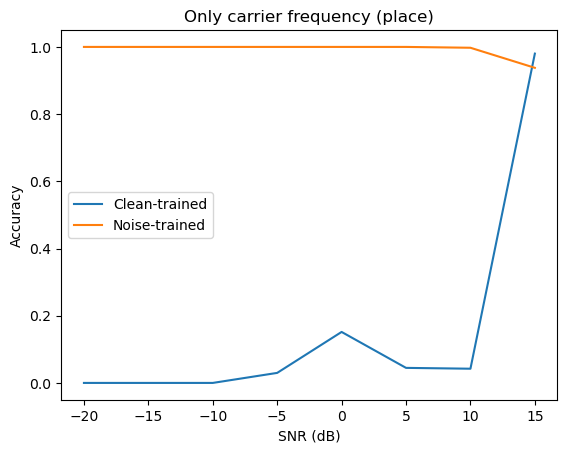

In [8]:
plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 15
plt.plot(plot_snr, test_accuracy_cleanMLP, label="Clean-trained")
plt.plot(plot_snr, test_accuracy_noisyMLP, label="Noise-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Only carrier frequency (place)")
plt.legend()

In [ ]:
out_PSDvIHC_classify_file = root_data_dir + 'PSDvIHC_classify_out'
np.savez(out_PSDvIHC_classify_file + '.npz', all_snrs=all_snrs, test_accuracy_noisyMLP=test_accuracy_noisyMLP, test_accuracy_cleanMLP=test_accuracy_cleanMLP)
mat_dict= {"all_snrs":all_snrs, "test_accuracy_noisyMLP":test_accuracy_noisyMLP, "test_accuracy_cleanMLP":test_accuracy_cleanMLP}
savemat(out_PSDvIHC_classify_file + '.mat', mat_dict)